# **INDIAN PINES**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00


Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 9.35 ms
0:	learn: 2.6105418	total: 129ms	remaining: 2m 9s
50:	learn: 0.8612363	total: 3.72s	remaining: 1m 9s
100:	learn: 0.6206615	total: 8.02s	remaining: 1m 11s
150:	learn: 0.5374138	total: 9.38s	remaining: 52.7s
200:	learn: 0.4960052	total: 10.8s	remaining: 42.9s
250:	learn: 0.4715711	total: 12.2s	remaining: 36.3s
300:	learn: 0.4519626	total: 13.6s	remaining: 31.5s
350:	learn: 0.4365905	total: 15s	remaining: 27.7s
400:	learn: 0.4246300	total: 16.8s	remaining: 25.1s
450:	learn: 0.4130854	total: 19.7s	remaining: 23.9s
500:	learn: 0.4026922	total: 21s	remaining: 21s
550:	learn: 0.3930714	total: 22.4s	remaining: 18.3s
600:	learn: 0.3837722	total: 23.8s	remaining: 15.8s
650:	learn: 0.3755704	total: 25.3s	remaining: 13.5s
700:	learn: 0.3671720	total: 26.6s	remaining: 11.4s
750:	learn: 0.3593792	total: 28s	remaining: 9.28s
800:	learn: 0.3512848	total: 29.4s	remaining: 7.3s
850:	learn: 0.3437563	total: 32.2s	

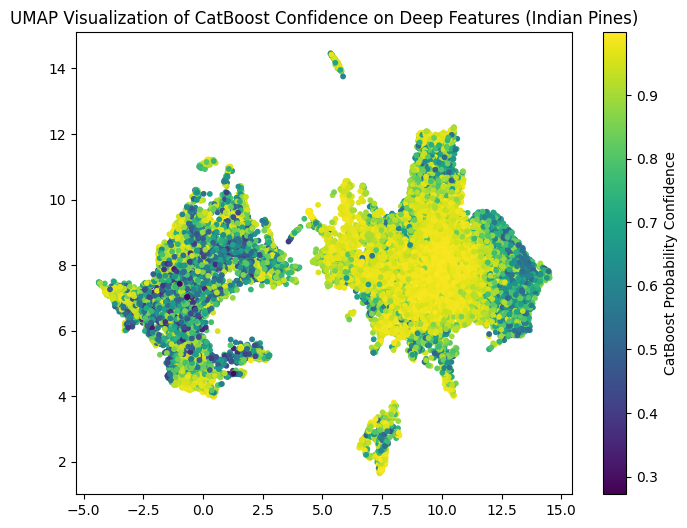

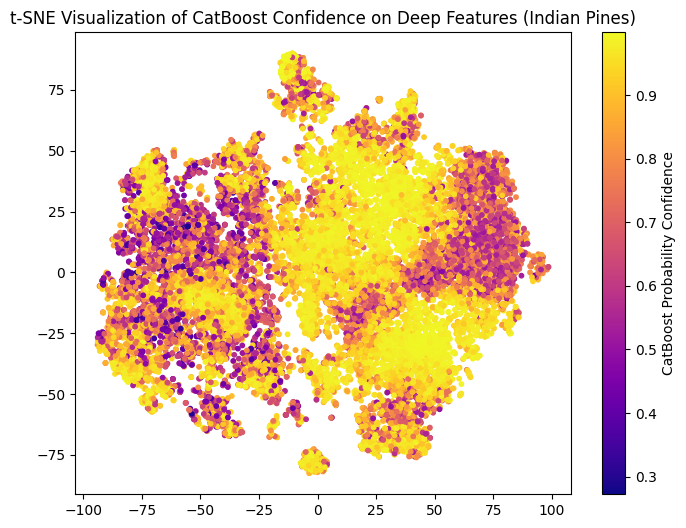

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
import seaborn as sns
import time

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Probabilities
catboost_probs = catboost_model.predict_proba(deep_features)
max_probs = np.max(catboost_probs, axis=1)  # Softmax confidence for visualization

# ✅ UMAP Visualization
def plot_umap(features, probs):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)
    plt.figure(figsize=(8,6))
    sc = plt.scatter(embedding[:, 0], embedding[:, 1], c=probs, cmap='viridis', s=10)
    plt.colorbar(sc, label='CatBoost Probability Confidence')
    plt.title("UMAP Visualization of CatBoost Confidence on Deep Features (Indian Pines)")
    plt.show()

# ✅ t-SNE Visualization
def plot_tsne(features, probs):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    embedding = tsne.fit_transform(features)
    plt.figure(figsize=(8,6))
    sc = plt.scatter(embedding[:, 0], embedding[:, 1], c=probs, cmap='plasma', s=10)
    plt.colorbar(sc, label='CatBoost Probability Confidence')
    plt.title("t-SNE Visualization of CatBoost Confidence on Deep Features (Indian Pines)")
    plt.show()

# ✅ Plot Both Visualizations
plot_umap(deep_features, max_probs)
plot_tsne(deep_features, max_probs)

In [ ]:
average_confidence = np.mean(max_probs)
print(f"🔍 Average CatBoost Confidence (Indian Pines): {average_confidence:.4f}")

🔍 Average CatBoost Confidence (Indian Pines): 0.8354


In [ ]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import os
import seaborn as sns
import time
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from catboost import CatBoostClassifier, Pool
from matplotlib import pyplot as plt

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")

# ✅ Visualize Grad-CAM for CNN Path
sample_idx = 0  # You can loop or visualize a few samples
input_sample = X_tensor[sample_idx].unsqueeze(0).to(device)  # Shape: [1, 200]

# We need to wrap the feature extractor in a model that allows hooks
class FeatureWrapper(nn.Module):
    def __init__(self, extractor):
        super().__init__()
        self.extractor = extractor

    def forward(self, x):
        return self.extractor(x)

# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 22.65 ms
0:	learn: 2.6105416	total: 117ms	remaining: 1m 56s
50:	learn: 0.8612363	total: 1.76s	remaining: 32.9s
100:	learn: 0.6206616	total: 4.66s	remaining: 41.5s
150:	learn: 0.5374138	total: 7.82s	remaining: 44s
200:	learn: 0.4960051	total: 11.5s	remaining: 45.7s
250:	learn: 0.4715711	total: 16.3s	remaining: 48.7s
300:	learn: 0.4519625	total: 19.7s	remaining: 45.8s
350:	learn: 0.4365905	total: 23s	remaining: 42.5s
400:	learn: 0.4246301	total: 27.1s	remaining: 40.5s
450:	learn: 0.4130854	total: 29.1s	remaining: 35.4s
500:	learn: 0.4026922	total: 30.6s	remaining: 30.4s
550:	learn: 0.3930714	total: 32s	remaining: 26.1s
600:	learn: 0.3837722	total: 33.4s	remaining: 22.2s
650:	learn: 0.3755703	total: 34.9s	remaining: 18.7s
700:	learn: 0.3671719	total: 36.3s	remaining: 15.5s
750:	learn: 0.3593792	total: 37.7s	remaining: 12.5s
800:	learn: 0.3512846	total: 40.7s	remaining: 10.1s
850:	learn: 0.3437563	total: 42

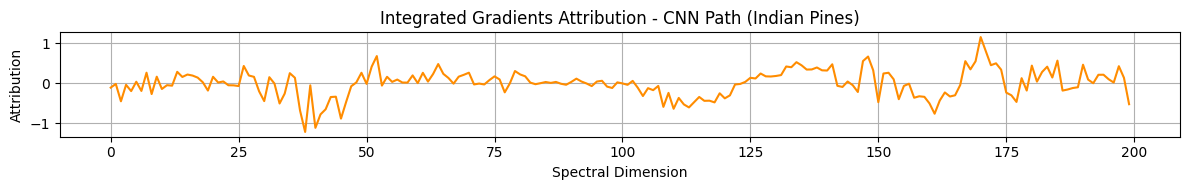

In [ ]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

# ✅ Wrap the CNN feature extractor
wrapped_model = FeatureWrapper(model.feature_extractor).to(device)
wrapped_model.eval()

# ✅ Select one input sample
sample_idx = 0
input_sample = X_tensor[sample_idx].unsqueeze(0).to(device)  # [1, 200]

# ✅ Enable gradient tracking
input_sample.requires_grad_()

# ✅ Create Integrated Gradients object
ig = IntegratedGradients(wrapped_model)

# ✅ Get prediction output for baseline class
output = wrapped_model(input_sample)
target_class = int(y_pred[sample_idx])  # Use predicted or true class

# ✅ Attribution computation
attributions, delta = ig.attribute(
    inputs=input_sample,
    target=target_class,
    return_convergence_delta=True,
    baselines=torch.zeros_like(input_sample)
)

# ✅ Convert to NumPy
attr = attributions.squeeze().detach().cpu().numpy()

# ✅ Plot
plt.figure(figsize=(12, 2))
plt.plot(attr, color="darkorange")
plt.title("Integrated Gradients Attribution - CNN Path (Indian Pines)")
plt.xlabel("Spectral Dimension")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()

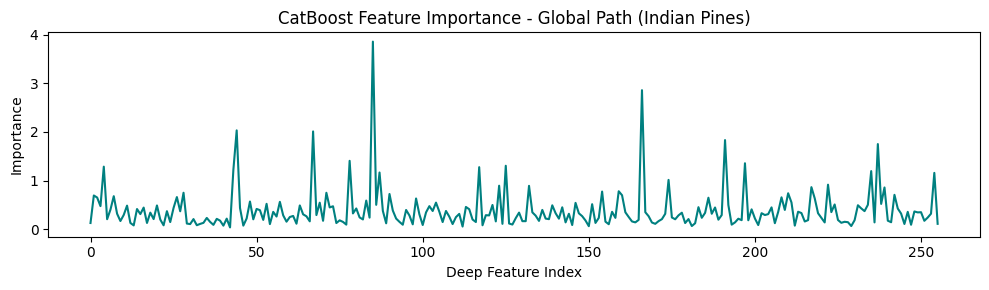

In [ ]:
# ✅ Feature Importance - CatBoost (Global Path)
importances = catboost_model.get_feature_importance()
plt.figure(figsize=(10, 3))
plt.plot(importances, color='teal')
plt.title("CatBoost Feature Importance - Global Path (Indian Pines)")
plt.xlabel("Deep Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
input_sample.requires_grad = True
out = wrapped_model(input_sample)
loss = out[0, target_class]
loss.backward()
print(input_sample.grad)  # Should not be None or all-zero


tensor([[[-0.0147],
         [-0.1948],
         [-0.5007],
         [-0.1140],
         [-0.3399],
         [ 0.2428],
         [-0.2531],
         [ 0.5994],
         [-0.5209],
         [ 0.4967],
         [-0.1934],
         [-0.0812],
         [ 0.0161],
         [ 0.5548],
         [ 0.5751],
         [ 0.5138],
         [ 0.4655],
         [ 0.4603],
         [ 0.0745],
         [-0.4400],
         [-0.0584],
         [-0.2509],
         [-0.1849],
         [-0.1789],
         [-0.1308],
         [ 0.0292],
         [ 0.8878],
         [ 0.4649],
         [ 0.3873],
         [-0.5711],
         [-1.0166],
         [ 0.1120],
         [-0.0227],
         [-1.6885],
         [-1.8932],
         [-1.0269],
         [-0.3608],
         [ 1.1891],
         [ 1.8624],
         [ 0.2739],
         [ 1.7422],
         [ 1.2034],
         [ 1.0409],
         [ 0.7042],
         [ 0.7129],
         [ 1.2675],
         [ 0.8130],
         [ 0.2553],
         [ 0.1794],
         [-0.2923],


In [ ]:
print(wrapped_model)

FeatureWrapper(
  (extractor): Sequential(
    (0): Conv1d(200, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=1)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=128, out_features=256, bias=True)
  )
)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time

**500 ITERATIONS**

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 952.14 ms
0:	learn: 2.7581809	total: 98.5ms	remaining: 49.1s
50:	learn: 1.4643460	total: 2.75s	remaining: 24.2s
100:	learn: 1.0739483	total: 5.22s	remaining: 20.6s
150:	learn: 0.8726940	total: 6.67s	remaining: 15.4s
200:	learn: 0.7523784	total: 8.12s	remaining: 12.1s
250:	learn: 0.6765565	total: 9.53s	remaining: 9.46s
300:	learn: 0.6244282	total: 10.9s	remaining: 7.23s
350:	learn: 0.5880655	total: 12.4s	remaining: 5.25s
400:	learn: 0.5610625	total: 13.8s	remaining: 3.42s
450:	learn: 0.5396534	total: 16.2s	remaining: 1.76s
499:	learn: 0.5230910	total: 18.6s	remaining: 0us
Final Iterations Used: 500
Learning Rate Used: 0.01
Final Accuracy: 0.8052
Final Kappa: 0.7188
Final ARI: 0.5794


In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 17.42 ms
0:	learn: 2.6105418	total: 65.2ms	remaining: 32.5s
50:	learn: 0.8612364	total: 1.56s	remaining: 13.7s
100:	learn: 0.6206616	total: 2.91s	remaining: 11.5s
150:	learn: 0.5374138	total: 5.27s	remaining: 12.2s
200:	learn: 0.4960052	total: 7.59s	remaining: 11.3s
250:	learn: 0.4715710	total: 8.96s	remaining: 8.89s
300:	learn: 0.4519626	total: 10.4s	remaining: 6.85s
350:	learn: 0.4365905	total: 11.8s	remaining: 5.01s
400:	learn: 0.4246300	total: 13.2s	remaining: 3.25s
450:	learn: 0.4130854	total: 14.6s	remaining: 1.58s
499:	learn: 0.4028540	total: 15.9s	remaining: 0us
Final Iterations Used: 500
Learning Rate Used: 0.03
Final Accuracy: 0.8493
Final Kappa: 0.7854
Final ARI: 0.6666


In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.001,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 8.48 ms
0:	learn: 2.8256761	total: 63.3ms	remaining: 31.6s
50:	learn: 2.5156501	total: 1.64s	remaining: 14.4s
100:	learn: 2.2965714	total: 3.1s	remaining: 12.2s
150:	learn: 2.1268354	total: 5s	remaining: 11.6s
200:	learn: 1.9889306	total: 7.86s	remaining: 11.7s
250:	learn: 1.8738111	total: 9.31s	remaining: 9.24s
300:	learn: 1.7749699	total: 10.8s	remaining: 7.15s
350:	learn: 1.6881932	total: 12.3s	remaining: 5.23s
400:	learn: 1.6112325	total: 13.9s	remaining: 3.43s
450:	learn: 1.5421621	total: 15.4s	remaining: 1.68s
499:	learn: 1.4814230	total: 17s	remaining: 0us
Final Iterations Used: 500
Learning Rate Used: 0.001
Final Accuracy: 0.7434
Final Kappa: 0.6100
Final ARI: 0.4751


In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.003,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 9.99 ms
0:	learn: 2.8106261	total: 76.4ms	remaining: 38.1s
50:	learn: 2.1182816	total: 2.28s	remaining: 20.1s
100:	learn: 1.7690545	total: 3.73s	remaining: 14.8s
150:	learn: 1.5376073	total: 5.14s	remaining: 11.9s
200:	learn: 1.3690092	total: 6.56s	remaining: 9.76s
250:	learn: 1.2398793	total: 8.01s	remaining: 7.95s
300:	learn: 1.1376070	total: 9.42s	remaining: 6.23s
350:	learn: 1.0540095	total: 12.5s	remaining: 5.29s
400:	learn: 0.9842675	total: 14.1s	remaining: 3.49s
450:	learn: 0.9257734	total: 15.6s	remaining: 1.69s
499:	learn: 0.8774698	total: 17s	remaining: 0us
Final Iterations Used: 500
Learning Rate Used: 0.003
Final Accuracy: 0.7707
Final Kappa: 0.6577
Final ARI: 0.5165


In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 9.27 ms
0:	learn: 2.4667005	total: 116ms	remaining: 58.1s
50:	learn: 0.6715478	total: 2.49s	remaining: 21.9s
100:	learn: 0.5232783	total: 3.86s	remaining: 15.3s
150:	learn: 0.4733438	total: 5.29s	remaining: 12.2s
200:	learn: 0.4419640	total: 6.69s	remaining: 9.96s
250:	learn: 0.4196280	total: 9.29s	remaining: 9.21s
300:	learn: 0.4016975	total: 11.4s	remaining: 7.55s
350:	learn: 0.3855163	total: 12.8s	remaining: 5.44s
400:	learn: 0.3717342	total: 14.2s	remaining: 3.51s
450:	learn: 0.3584774	total: 15.6s	remaining: 1.7s
499:	learn: 0.3466324	total: 17s	remaining: 0us
Final Iterations Used: 500
Learning Rate Used: 0.05
Final Accuracy: 0.8737
Final Kappa: 0.8205
Final ARI: 0.7144


In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.005,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 10.14 ms
0:	learn: 2.7956040	total: 78ms	remaining: 38.9s
50:	learn: 1.8605347	total: 1.6s	remaining: 14.1s
100:	learn: 1.4719748	total: 3.07s	remaining: 12.1s
150:	learn: 1.2369489	total: 4.48s	remaining: 10.4s
200:	learn: 1.0772034	total: 5.91s	remaining: 8.79s
250:	learn: 0.9616169	total: 7.29s	remaining: 7.23s
300:	learn: 0.8738736	total: 8.71s	remaining: 5.75s
350:	learn: 0.8062272	total: 10.2s	remaining: 4.34s
400:	learn: 0.7528708	total: 13.4s	remaining: 3.31s
450:	learn: 0.7104600	total: 14.8s	remaining: 1.61s
499:	learn: 0.6765667	total: 16.2s	remaining: 0us
Final Iterations Used: 500
Learning Rate Used: 0.005
Final Accuracy: 0.7856
Final Kappa: 0.6842
Final ARI: 0.5424


**1000 ITERATIONS**

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 10.74 ms
0:	learn: 2.7581809	total: 109ms	remaining: 1m 48s
50:	learn: 1.4643459	total: 2.79s	remaining: 51.8s
100:	learn: 1.0739481	total: 4.35s	remaining: 38.7s
150:	learn: 0.8726941	total: 5.77s	remaining: 32.5s
200:	learn: 0.7523784	total: 7.22s	remaining: 28.7s
250:	learn: 0.6765566	total: 8.63s	remaining: 25.7s
300:	learn: 0.6244280	total: 11.4s	remaining: 26.5s
350:	learn: 0.5880655	total: 13.3s	remaining: 24.6s
400:	learn: 0.5610624	total: 14.9s	remaining: 22.2s
450:	learn: 0.5396533	total: 16.4s	remaining: 20s
500:	learn: 0.5228080	total: 17.9s	remaining: 17.9s
550:	learn: 0.5089489	total: 19.4s	remaining: 15.8s
600:	learn: 0.4976035	total: 20.8s	remaining: 13.8s
650:	learn: 0.4877181	total: 22.3s	remaining: 12s
700:	learn: 0.4788651	total: 25.5s	remaining: 10.9s
750:	learn: 0.4711696	total: 26.9s	remaining: 8.93s
800:	learn: 0.4642640	total: 28.3s	remaining: 7.04s
850:	learn: 0.4579512	total: 

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.001,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 9.61 ms
0:	learn: 2.8256765	total: 137ms	remaining: 2m 16s
50:	learn: 2.5156495	total: 4.09s	remaining: 1m 16s
100:	learn: 2.2965712	total: 6.4s	remaining: 57s
150:	learn: 2.1268352	total: 8.37s	remaining: 47.1s
200:	learn: 1.9889311	total: 9.85s	remaining: 39.2s
250:	learn: 1.8738115	total: 11.3s	remaining: 33.9s
300:	learn: 1.7749697	total: 13.3s	remaining: 30.8s
350:	learn: 1.6881930	total: 16.1s	remaining: 29.8s
400:	learn: 1.6112327	total: 17.7s	remaining: 26.4s
450:	learn: 1.5421620	total: 19.1s	remaining: 23.3s
500:	learn: 1.4802454	total: 20.6s	remaining: 20.5s
550:	learn: 1.4242535	total: 22.1s	remaining: 18s
600:	learn: 1.3730291	total: 23.5s	remaining: 15.6s
650:	learn: 1.3262617	total: 24.9s	remaining: 13.4s
700:	learn: 1.2831691	total: 26.7s	remaining: 11.4s
750:	learn: 1.2433802	total: 29.7s	remaining: 9.83s
800:	learn: 1.2065924	total: 31.1s	remaining: 7.72s
850:	learn: 1.1721675	total: 3

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 10.98 ms
0:	learn: 2.6105414	total: 103ms	remaining: 1m 43s
50:	learn: 0.8612365	total: 3.12s	remaining: 58s
100:	learn: 0.6206615	total: 6.02s	remaining: 53.6s
150:	learn: 0.5374137	total: 9s	remaining: 50.6s
200:	learn: 0.4960052	total: 10.4s	remaining: 41.3s
250:	learn: 0.4715710	total: 11.8s	remaining: 35.1s
300:	learn: 0.4519626	total: 13.1s	remaining: 30.5s
350:	learn: 0.4365904	total: 14.5s	remaining: 26.9s
400:	learn: 0.4246300	total: 15.9s	remaining: 23.8s
450:	learn: 0.4130854	total: 17.3s	remaining: 21s
500:	learn: 0.4026922	total: 18.6s	remaining: 18.6s
550:	learn: 0.3930714	total: 21.4s	remaining: 17.4s
600:	learn: 0.3837722	total: 23.2s	remaining: 15.4s
650:	learn: 0.3755704	total: 24.6s	remaining: 13.2s
700:	learn: 0.3671721	total: 26s	remaining: 11.1s
750:	learn: 0.3593792	total: 27.4s	remaining: 9.08s
800:	learn: 0.3512848	total: 28.8s	remaining: 7.15s
850:	learn: 0.3437563	total: 30.2s

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.003,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 15.03 ms
0:	learn: 2.8106257	total: 81.1ms	remaining: 1m 21s
50:	learn: 2.1182811	total: 3.09s	remaining: 57.6s
100:	learn: 1.7690545	total: 5.19s	remaining: 46.2s
150:	learn: 1.5376075	total: 6.6s	remaining: 37.1s
200:	learn: 1.3690090	total: 8.12s	remaining: 32.3s
250:	learn: 1.2398795	total: 11.2s	remaining: 33.4s
300:	learn: 1.1376070	total: 12.7s	remaining: 29.5s
350:	learn: 1.0540095	total: 14.2s	remaining: 26.2s
400:	learn: 0.9842674	total: 16s	remaining: 23.9s
450:	learn: 0.9257735	total: 18.9s	remaining: 23s
500:	learn: 0.8765588	total: 20.3s	remaining: 20.2s
550:	learn: 0.8330737	total: 22.4s	remaining: 18.2s
600:	learn: 0.7960732	total: 25.1s	remaining: 16.6s
650:	learn: 0.7641694	total: 26.5s	remaining: 14.2s
700:	learn: 0.7360780	total: 28s	remaining: 11.9s
750:	learn: 0.7114991	total: 29.4s	remaining: 9.75s
800:	learn: 0.6901782	total: 30.8s	remaining: 7.66s
850:	learn: 0.6711625	total: 32

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 9.39 ms
0:	learn: 2.4667009	total: 63.3ms	remaining: 1m 3s
50:	learn: 0.6715479	total: 1.57s	remaining: 29.3s
100:	learn: 0.5232784	total: 2.96s	remaining: 26.3s
150:	learn: 0.4733438	total: 4.34s	remaining: 24.4s
200:	learn: 0.4419639	total: 5.74s	remaining: 22.8s
250:	learn: 0.4196280	total: 7.15s	remaining: 21.3s
300:	learn: 0.4016975	total: 8.53s	remaining: 19.8s
350:	learn: 0.3855164	total: 10.4s	remaining: 19.2s
400:	learn: 0.3717342	total: 13.1s	remaining: 19.6s
450:	learn: 0.3584775	total: 14.6s	remaining: 17.7s
500:	learn: 0.3463574	total: 16s	remaining: 15.9s
550:	learn: 0.3354453	total: 17.4s	remaining: 14.1s
600:	learn: 0.3246117	total: 18.8s	remaining: 12.5s
650:	learn: 0.3150327	total: 20.2s	remaining: 10.8s
700:	learn: 0.3059427	total: 21.6s	remaining: 9.23s
750:	learn: 0.2971187	total: 23.4s	remaining: 7.75s
800:	learn: 0.2880152	total: 26.4s	remaining: 6.55s
850:	learn: 0.2795196	total:

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.005,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 8.58 ms
0:	learn: 2.7956044	total: 129ms	remaining: 2m 9s
50:	learn: 1.8605349	total: 3.08s	remaining: 57.3s
100:	learn: 1.4719747	total: 5.51s	remaining: 49.1s
150:	learn: 1.2369488	total: 6.92s	remaining: 38.9s
200:	learn: 1.0772034	total: 8.33s	remaining: 33.1s
250:	learn: 0.9616172	total: 9.71s	remaining: 29s
300:	learn: 0.8738736	total: 12.1s	remaining: 28.2s
350:	learn: 0.8062271	total: 14.4s	remaining: 26.7s
400:	learn: 0.7528708	total: 15.9s	remaining: 23.7s
450:	learn: 0.7104601	total: 17.3s	remaining: 21s
500:	learn: 0.6759609	total: 18.7s	remaining: 18.6s
550:	learn: 0.6474619	total: 20.1s	remaining: 16.4s
600:	learn: 0.6235104	total: 21.5s	remaining: 14.3s
650:	learn: 0.6035476	total: 22.9s	remaining: 12.3s
700:	learn: 0.5865189	total: 25.1s	remaining: 10.7s
750:	learn: 0.5718814	total: 27.5s	remaining: 9.12s
800:	learn: 0.5592194	total: 28.9s	remaining: 7.18s
850:	learn: 0.5480756	total: 30

**1500 ITERATIONS**

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.01,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 8.42 ms
0:	learn: 2.7581811	total: 65ms	remaining: 1m 37s
50:	learn: 1.4643460	total: 1.61s	remaining: 45.7s
100:	learn: 1.0739482	total: 3.04s	remaining: 42.1s
150:	learn: 0.8726940	total: 4.42s	remaining: 39.5s
200:	learn: 0.7523784	total: 6.86s	remaining: 44.3s
250:	learn: 0.6765564	total: 9.08s	remaining: 45.2s
300:	learn: 0.6244281	total: 10.5s	remaining: 41.7s
350:	learn: 0.5880655	total: 11.8s	remaining: 38.7s
400:	learn: 0.5610627	total: 13.2s	remaining: 36.2s
450:	learn: 0.5396534	total: 14.7s	remaining: 34.1s
500:	learn: 0.5228079	total: 16.1s	remaining: 32.1s
550:	learn: 0.5089488	total: 17.5s	remaining: 30.2s
600:	learn: 0.4976035	total: 19.7s	remaining: 29.5s
650:	learn: 0.4877181	total: 22.2s	remaining: 29s
700:	learn: 0.4788651	total: 23.7s	remaining: 27s
750:	learn: 0.4711696	total: 25.1s	remaining: 25s
800:	learn: 0.4642641	total: 26.5s	remaining: 23.1s
850:	learn: 0.4579511	total: 28s	

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.001,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 11.99 ms
0:	learn: 2.8256757	total: 128ms	remaining: 3m 11s
50:	learn: 2.5156501	total: 3.39s	remaining: 1m 36s
100:	learn: 2.2965710	total: 7.6s	remaining: 1m 45s
150:	learn: 2.1268354	total: 9.7s	remaining: 1m 26s
200:	learn: 1.9889308	total: 11.1s	remaining: 1m 11s
250:	learn: 1.8738113	total: 12.5s	remaining: 1m 2s
300:	learn: 1.7749701	total: 14s	remaining: 55.7s
350:	learn: 1.6881932	total: 15.4s	remaining: 50.5s
400:	learn: 1.6112325	total: 17.5s	remaining: 48s
450:	learn: 1.5421620	total: 20.2s	remaining: 47.1s
500:	learn: 1.4802454	total: 21.6s	remaining: 43.2s
550:	learn: 1.4242535	total: 23.1s	remaining: 39.7s
600:	learn: 1.3730293	total: 24.5s	remaining: 36.7s
650:	learn: 1.3262616	total: 25.9s	remaining: 33.8s
700:	learn: 1.2831689	total: 27.4s	remaining: 31.2s
750:	learn: 1.2433800	total: 28.8s	remaining: 28.7s
800:	learn: 1.2065923	total: 30.7s	remaining: 26.8s
850:	learn: 1.1721672	total

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 9.66 ms
0:	learn: 2.6105414	total: 87.7ms	remaining: 2m 11s
50:	learn: 0.8612363	total: 3.15s	remaining: 1m 29s
100:	learn: 0.6206614	total: 7.57s	remaining: 1m 44s
150:	learn: 0.5374137	total: 10.4s	remaining: 1m 32s
200:	learn: 0.4960052	total: 12.7s	remaining: 1m 21s
250:	learn: 0.4715711	total: 14.1s	remaining: 1m 10s
300:	learn: 0.4519626	total: 15.5s	remaining: 1m 1s
350:	learn: 0.4365905	total: 16.9s	remaining: 55.2s
400:	learn: 0.4246300	total: 18.9s	remaining: 51.9s
450:	learn: 0.4130854	total: 21.5s	remaining: 49.9s
500:	learn: 0.4026923	total: 22.8s	remaining: 45.6s
550:	learn: 0.3930714	total: 24.2s	remaining: 41.7s
600:	learn: 0.3837722	total: 25.7s	remaining: 38.4s
650:	learn: 0.3755703	total: 27.1s	remaining: 35.3s
700:	learn: 0.3671720	total: 28.5s	remaining: 32.4s
750:	learn: 0.3593792	total: 29.9s	remaining: 29.8s
800:	learn: 0.3512848	total: 31.7s	remaining: 27.6s
850:	learn: 0.343756

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.003,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 12.38 ms
0:	learn: 2.8106259	total: 178ms	remaining: 4m 27s
50:	learn: 2.1182812	total: 4.28s	remaining: 2m 1s
100:	learn: 1.7690547	total: 6.92s	remaining: 1m 35s
150:	learn: 1.5376074	total: 10.1s	remaining: 1m 30s
200:	learn: 1.3690093	total: 13.9s	remaining: 1m 29s
250:	learn: 1.2398797	total: 18.9s	remaining: 1m 34s
300:	learn: 1.1376073	total: 21.1s	remaining: 1m 24s
350:	learn: 1.0540095	total: 23.5s	remaining: 1m 16s
400:	learn: 0.9842676	total: 25.5s	remaining: 1m 9s
450:	learn: 0.9257736	total: 28.7s	remaining: 1m 6s
500:	learn: 0.8765586	total: 31.8s	remaining: 1m 3s
550:	learn: 0.8330736	total: 34s	remaining: 58.6s
600:	learn: 0.7960732	total: 36.6s	remaining: 54.8s
650:	learn: 0.7641696	total: 38.9s	remaining: 50.7s
700:	learn: 0.7360780	total: 42.5s	remaining: 48.4s
750:	learn: 0.7114991	total: 45.3s	remaining: 45.1s
800:	learn: 0.6901783	total: 47.7s	remaining: 41.6s
850:	learn: 0.6711624

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 6.60 ms
0:	learn: 2.4667005	total: 30ms	remaining: 45s
50:	learn: 0.6715479	total: 1.52s	remaining: 43.1s
100:	learn: 0.5232784	total: 2.9s	remaining: 40.1s
150:	learn: 0.4733438	total: 4.28s	remaining: 38.2s
200:	learn: 0.4419639	total: 5.67s	remaining: 36.6s
250:	learn: 0.4196280	total: 8.44s	remaining: 42s
300:	learn: 0.4016975	total: 10.4s	remaining: 41.6s
350:	learn: 0.3855163	total: 11.8s	remaining: 38.7s
400:	learn: 0.3717341	total: 13.3s	remaining: 36.3s
450:	learn: 0.3584774	total: 16.2s	remaining: 37.7s
500:	learn: 0.3463573	total: 17.9s	remaining: 35.7s
550:	learn: 0.3354453	total: 19.2s	remaining: 33.1s
600:	learn: 0.3246117	total: 21.9s	remaining: 32.8s
650:	learn: 0.3150327	total: 23.9s	remaining: 31.1s
700:	learn: 0.3059428	total: 25.3s	remaining: 28.8s
750:	learn: 0.2971187	total: 27.3s	remaining: 27.3s
800:	learn: 0.2880152	total: 28.7s	remaining: 25.1s
850:	learn: 0.2795196	total: 30.1

In [ ]:
# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.005,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 11.31 ms
0:	learn: 2.7956046	total: 107ms	remaining: 2m 40s
50:	learn: 1.8605349	total: 1.69s	remaining: 47.9s
100:	learn: 1.4719748	total: 3.2s	remaining: 44.3s
150:	learn: 1.2369489	total: 4.63s	remaining: 41.4s
200:	learn: 1.0772034	total: 6.07s	remaining: 39.3s
250:	learn: 0.9616170	total: 7.51s	remaining: 37.4s
300:	learn: 0.8738736	total: 8.95s	remaining: 35.6s
350:	learn: 0.8062273	total: 10.7s	remaining: 35s
400:	learn: 0.7528708	total: 13.7s	remaining: 37.6s
450:	learn: 0.7104601	total: 15.2s	remaining: 35.3s
500:	learn: 0.6759609	total: 16.7s	remaining: 33.2s
550:	learn: 0.6474621	total: 18.1s	remaining: 31.1s
600:	learn: 0.6235102	total: 19.5s	remaining: 29.1s
650:	learn: 0.6035477	total: 20.9s	remaining: 27.3s
700:	learn: 0.5865189	total: 22.3s	remaining: 25.4s
750:	learn: 0.5718814	total: 23.7s	remaining: 23.7s
800:	learn: 0.5592194	total: 26.8s	remaining: 23.4s
850:	learn: 0.5480756	total:

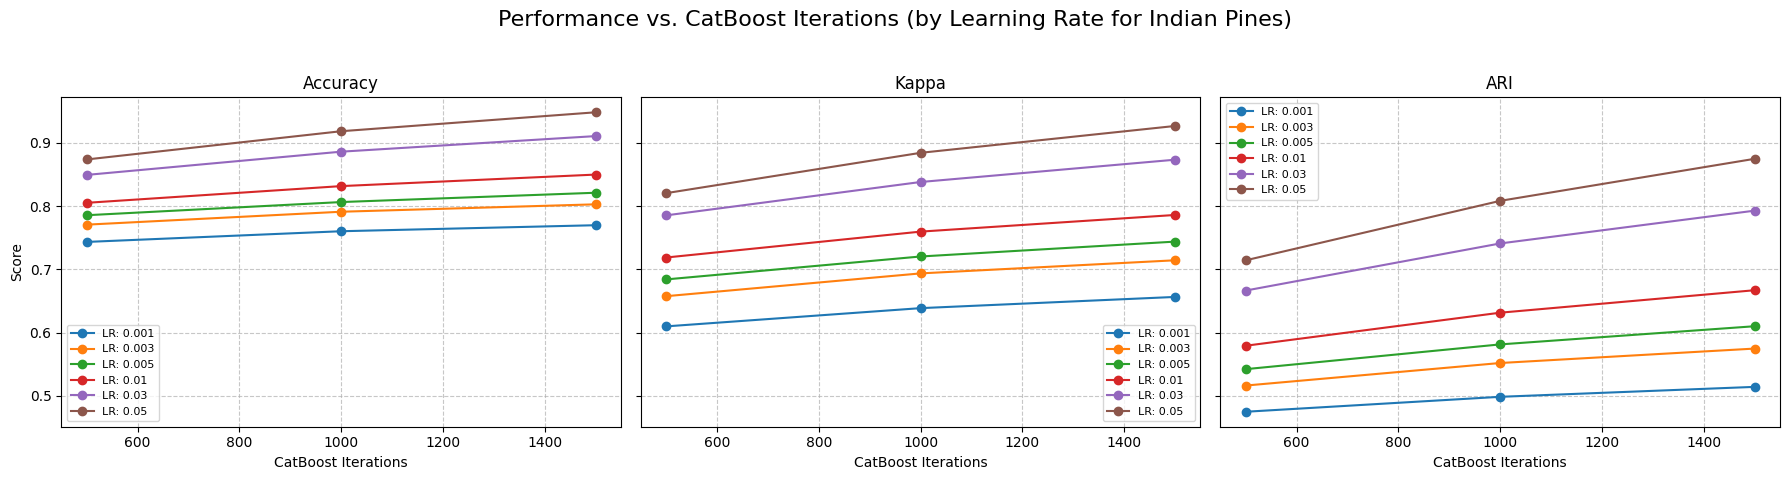

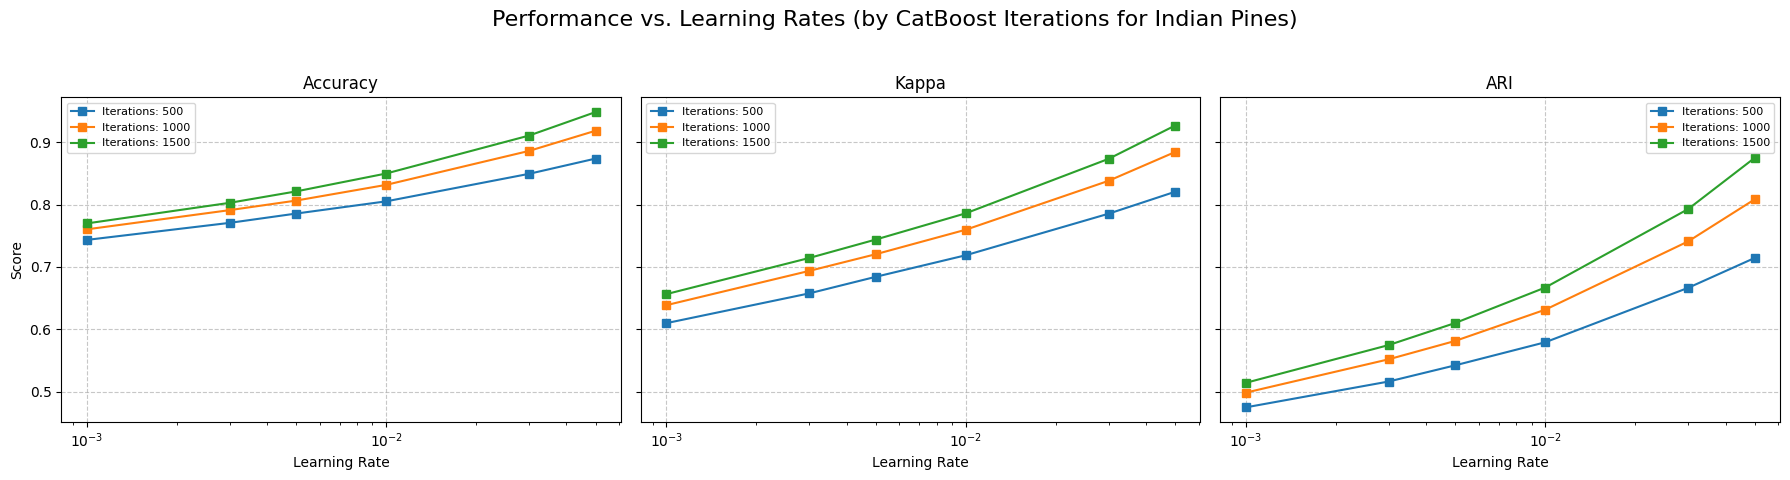

---
## Sensitivity Table
 Iterations  Learning Rate  Accuracy (%)  Kappa    ARI
      500.0          0.001         74.34 0.6100 0.4751
      500.0          0.003         77.07 0.6577 0.5165
      500.0          0.005         78.56 0.6842 0.5424
      500.0          0.010         80.52 0.7188 0.5794
      500.0          0.030         84.93 0.7854 0.6666
      500.0          0.050         87.37 0.8205 0.7144
     1000.0          0.001         76.03 0.6388 0.4987
     1000.0          0.003         79.11 0.6937 0.5521
     1000.0          0.005         80.64 0.7204 0.5815
     1000.0          0.010         83.16 0.7597 0.6316
     1000.0          0.030         88.60 0.8381 0.7410
     1000.0          0.050         91.83 0.8842 0.8083
     1500.0          0.001         76.98 0.6565 0.5144
     1500.0          0.003         80.28 0.7144 0.5749
     1500.0          0.005         82.11 0.7439 0.6102
     1500.0          0.010         84.98 0.7860 0.6671
     1500.0          0.030         91.06

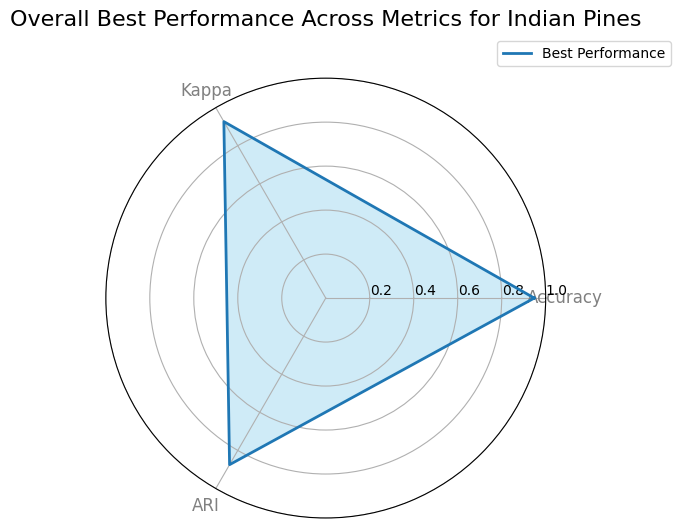

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import pi

# --- 1. Data Parsing ---
# Raw data provided in the problem description
data_string = """
1.Final Iterations Used: 500
Learning Rate Used: 0.01
Final Accuracy: 0.8052
Final Kappa: 0.7188
Final ARI: 0.5794

2.Final Iterations Used: 500
Learning Rate Used: 0.03
Final Accuracy: 0.8493
Final Kappa: 0.7854
Final ARI: 0.6666

3.Final Iterations Used: 500
Learning Rate Used: 0.001
Final Accuracy: 0.7434
Final Kappa: 0.6100
Final ARI: 0.4751

4.Final Iterations Used: 500
Learning Rate Used: 0.003
Final Accuracy: 0.7707
Final Kappa: 0.6577
Final ARI: 0.5165

5.Final Iterations Used: 500
Learning Rate Used: 0.05
Final Accuracy: 0.8737
Final Kappa: 0.8205
Final ARI: 0.7144

6.Final Iterations Used: 500
Learning Rate Used: 0.005
Final Accuracy: 0.7856
Final Kappa: 0.6842
Final ARI: 0.5424

7.Final Iterations Used: 1000
Learning Rate Used: 0.01
Final Accuracy: 0.8316
Final Kappa: 0.7597
Final ARI: 0.6316

8.Final Iterations Used: 1000
Learning Rate Used: 0.001
Final Accuracy: 0.7603
Final Kappa: 0.6388
Final ARI: 0.4987

9.Final Iterations Used: 1000
Learning Rate Used: 0.03
Final Accuracy: 0.8860
Final Kappa: 0.8381
Final ARI: 0.7410

10.Final Iterations Used: 1000
Learning Rate Used: 0.003
Final Accuracy: 0.7911
Final Kappa: 0.6937
Final ARI: 0.5521

11.Final Iterations Used: 1000
Learning Rate Used: 0.05
Final Accuracy: 0.9183
Final Kappa: 0.8842
Final ARI: 0.8083

12.Final Iterations Used: 1000
Learning Rate Used: 0.005
Final Accuracy: 0.8064
Final Kappa: 0.7204
Final ARI: 0.5815

13.Final Iterations Used: 1500
Learning Rate Used: 0.01
Final Accuracy: 0.8498
Final Kappa: 0.7860
Final ARI: 0.6671

14.Final Iterations Used: 1500
Learning Rate Used: 0.001
Final Accuracy: 0.7698
Final Kappa: 0.6565
Final ARI: 0.5144

15.Final Iterations Used: 1500
Learning Rate Used: 0.03
Final Accuracy: 0.9106
Final Kappa: 0.8733
Final ARI: 0.7928

16.Final Iterations Used: 1500
Learning Rate Used: 0.003
Final Accuracy: 0.8028
Final Kappa: 0.7144
Final ARI: 0.5749

17.Final Iterations Used: 1500
Learning Rate Used: 0.05
Final Accuracy: 0.9482
Final Kappa: 0.9266
Final ARI: 0.8747

18.Final Iterations Used: 1500
Learning Rate Used: 0.005
Final Accuracy: 0.8211
Final Kappa: 0.7439
Final ARI: 0.6102
"""

# Parse the data using regular expressions
data_entries = data_string.strip().split('\n\n')
parsed_data = []

for entry in data_entries:
    iterations = float(re.search(r'Final Iterations Used: (\d+)', entry).group(1))
    learning_rate = float(re.search(r'Learning Rate Used: (\d+\.\d+)', entry).group(1))
    accuracy = float(re.search(r'Final Accuracy: (\d+\.\d+)', entry).group(1))
    kappa = float(re.search(r'Final Kappa: (\d+\.\d+)', entry).group(1))
    ari = float(re.search(r'Final ARI: (\d+\.\d+)', entry).group(1))

    parsed_data.append({
        'Iterations': iterations,
        'Learning Rate': learning_rate,
        'Accuracy': accuracy,
        'Kappa': kappa,
        'ARI': ari
    })

# Create a Pandas DataFrame from the parsed data
df = pd.DataFrame(parsed_data)

# Sort the DataFrame for consistent plotting across different learning rates/iterations
df = df.sort_values(by=['Iterations', 'Learning Rate']).reset_index(drop=True)

# Get unique values for iterations and learning rates for plotting loops
unique_iterations = df['Iterations'].unique()
unique_learning_rates = df['Learning Rate'].unique()

# --- 2. Multi-line Plots ---
# Set a consistent color palette using Seaborn
colors = sns.color_palette("tab10")
metrics = ['Accuracy', 'Kappa', 'ARI']

# Plot 1: Performance vs. CatBoost Iterations (separated by Learning Rate)
# Create a figure with 3 subplots side by side
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig1.suptitle('Performance vs. CatBoost Iterations (by Learning Rate for Indian Pines)', fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes1[i]
    for j, lr in enumerate(unique_learning_rates):
        subset_df = df[df['Learning Rate'] == lr].sort_values(by='Iterations')
        ax.plot(subset_df['Iterations'], subset_df[metric], marker='o', color=colors[j], label=f'LR: {lr}')
    ax.set_title(metric)
    ax.set_xlabel('CatBoost Iterations')
    ax.grid(True, linestyle='--', alpha=0.7)
    if i == 0:
        ax.set_ylabel('Score')
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot 2: Performance vs. Learning Rates (separated by CatBoost Iterations)
# Create a figure with 3 subplots side by side
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig2.suptitle('Performance vs. Learning Rates (by CatBoost Iterations for Indian Pines)', fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes2[i]
    for j, iter_val in enumerate(unique_iterations):
        subset_df = df[df['Iterations'] == iter_val].sort_values(by='Learning Rate')
        ax.plot(subset_df['Learning Rate'], subset_df[metric], marker='s', color=colors[j], label=f'Iterations: {int(iter_val)}')
    ax.set_title(metric)
    ax.set_xlabel('Learning Rate')
    ax.set_xscale('log')
    ax.grid(True, linestyle='--', alpha=0.7)
    if i == 0:
        ax.set_ylabel('Score')
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 3. Sensitivity Table ---
print("---")
print("## Sensitivity Table")
# Prepare data for the sensitivity table. Since each configuration has only one run,
# standard deviation cannot be calculated.
sensitivity_df_display = df.copy()
sensitivity_df_display['Accuracy (%)'] = (sensitivity_df_display['Accuracy'] * 100).round(2)
sensitivity_df_display['Kappa'] = sensitivity_df_display['Kappa'].round(4)
sensitivity_df_display['ARI'] = sensitivity_df_display['ARI'].round(4)

# Reorder columns for display in the table
table_cols = ['Iterations', 'Learning Rate', 'Accuracy (%)', 'Kappa', 'ARI']
sensitivity_df_display = sensitivity_df_display[table_cols]

print(sensitivity_df_display.to_string(index=False))
print("---")

# --- 4. Generate CSV File ---
csv_file_name = 'sensitivity_table.csv'
sensitivity_df_display.to_csv(csv_file_name, index=False)

print(f"Sensitivity table saved to {csv_file_name}")

# --- 5. Combined Radar (Spider) Chart ---
print("## Combined Radar (Spider) Chart")

# For the radar chart, we'll use the maximum achieved value for each metric across all runs
categories = ['Accuracy', 'Kappa', 'ARI']
max_accuracy = df['Accuracy'].max()
max_kappa = df['Kappa'].max()
max_ari = df['ARI'].max()

values = [max_accuracy, max_kappa, max_ari]
values += values[:1] # Complete the loop for the radar chart

# Calculate angles for the radar chart points
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1] # Complete the loop

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True) # Create a polar plot

# Set labels for each axis
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Set the range for the radial axis. Assuming metrics are between 0 and 1.
ax.set_rlabel_position(0)
ax.set_ylim(0, 1)

# Plot the data
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Best Performance')
ax.fill(angles, values, 'skyblue', alpha=0.4) # Fill the area under the plot

# Add title and legend
plt.title('Overall Best Performance Across Metrics for Indian Pines', size=16, color='black', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1)) # Place legend outside
plt.tight_layout()
plt.show()

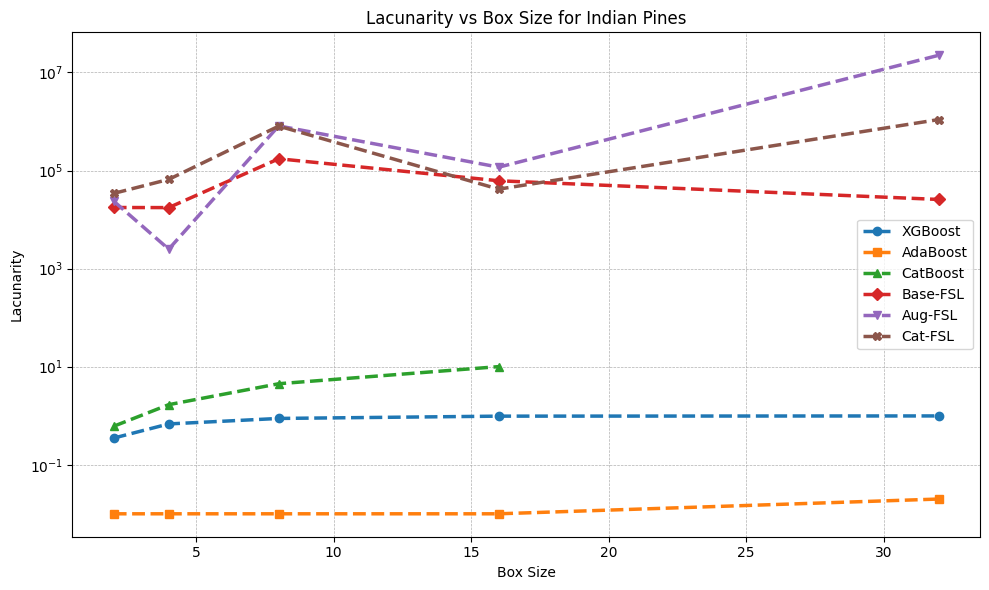

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

box_sizes = [2, 4, 8, 16, 32]

# Lacunarity values for each algorithm
xgboost = [0.35, 0.68, 0.88, 0.98, 0.99]
adaboost = [0.01, 0.01, 0.01, 0.01, 0.02]
catboost = [0.61, 1.68, 4.49, 10.03, np.nan]  # NaN for missing value

base_fsl = [17616.63, 17527.21, 173643.83, 61809.67, 25687.33]
aug_fsl = [23726.57, 2490.51, 812967.10, 117053.50, 22402720.00]
cat_fsl = [34140.62, 65917.69, 803828.50, 41700.57, 1094558.00]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(box_sizes, xgboost, marker='o', linestyle='--', label='XGBoost', linewidth=2.5)
plt.plot(box_sizes, adaboost, marker='s', linestyle='--', label='AdaBoost', linewidth=2.5)
plt.plot(box_sizes, catboost, marker='^', linestyle='--', label='CatBoost', linewidth=2.5)

plt.plot(box_sizes, base_fsl, marker='D', linestyle='--', label='Base-FSL', linewidth=2.5)
plt.plot(box_sizes, aug_fsl, marker='v', linestyle='--', label='Aug-FSL', linewidth=2.5)
plt.plot(box_sizes, cat_fsl, marker='X', linestyle='--', label='Cat-FSL', linewidth=2.5)

plt.xlabel("Box Size")
plt.ylabel("Lacunarity")
plt.title("Lacunarity vs Box Size for Indian Pines")
plt.yscale("log")  # Log scale for better visualization
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# **SALINAS**

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 94.25 ms
0:	learn: 2.5433988	total: 85.6ms	remaining: 1m 25s
50:	learn: 0.5831120	total: 2.24s	remaining: 41.7s
100:	learn: 0.3645335	total: 4.31s	remaining: 38.4s
150:	learn: 0.3058845	total: 6.34s	remaining: 35.6s
200:	learn: 0.2803316	total: 10.1s	remaining: 40.1s
250:	learn: 0.2665440	total: 12.1s	remaining: 36s
300:	learn: 0.2561171	total: 14s	remaining: 32.6s
350:	learn: 0.2481952	total: 16s	remaining: 29.6s
400:	learn: 0.2413034	total: 18s	remaining: 26.9s
450:	learn: 0.2355261	total: 20s	remaining: 24.3s
500:	learn: 0.2304631	total: 23.7s	remaining: 23.6s
550:	learn: 0.2259023	total: 25.7s	remaining: 21s
600:	learn: 0.2216661	total: 27.7s	remaining: 18.4s
650:	learn: 0.2177400	total: 29.7s	remaining: 15.9s
700:	learn: 0.2142483	total: 31.7s	remaining: 13.5s
750:	learn: 0.2110785	total: 33.9s	remaining: 11.3s
800:	learn: 0.2078806	total: 37.9s	remaining: 9.41s
850:	learn: 0.2050502	total: 39.8s	r

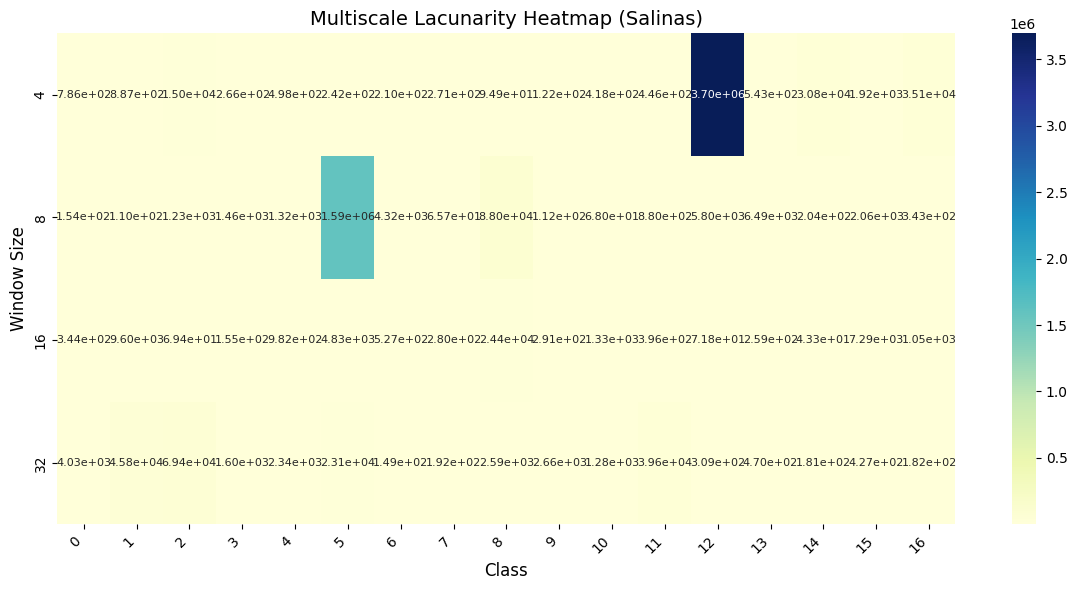

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),  # Changed 204 → 1
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -2].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

# ✅ Lacunarity Heatmap Code
def calculate_lacunarity(window_values):
    mean = np.mean(window_values)
    variance = np.var(window_values)
    return variance / (mean ** 2)

def lacunarity_heatmap(features, window_sizes=[4, 8, 16, 32], class_labels=None):
    heatmap_data = []
    for window_size in window_sizes:
        lacunarity_per_class = []
        for cls in np.unique(class_labels):
            cls_features = features[class_labels == cls]
            window_lacunarity = [
                calculate_lacunarity(cls_features[:, i:i+window_size].flatten())
                for i in range(0, cls_features.shape[1] - window_size, window_size)
            ]
            lacunarity_per_class.append(np.mean(window_lacunarity))
        heatmap_data.append(lacunarity_per_class)

    heatmap_array = np.array(heatmap_data)
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heatmap_array,
        xticklabels=np.unique(class_labels),
        yticklabels=window_sizes,
        annot=True,
        fmt=".2e",  # scientific notation with 2 decimals
        cmap="YlGnBu",
        annot_kws={"size": 8}
    )
    plt.title("Multiscale Lacunarity Heatmap (Salinas)", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Window Size", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# ✅ Call Lacunarity Heatmap on Deep Features and True Labels
lacunarity_heatmap(features=deep_features, class_labels=y_ground_truth)

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 93.71 ms
0:	learn: 2.5433994	total: 86ms	remaining: 1m 25s
50:	learn: 0.5831120	total: 3.96s	remaining: 1m 13s
100:	learn: 0.3645335	total: 6.04s	remaining: 53.8s
150:	learn: 0.3058845	total: 8.01s	remaining: 45s
200:	learn: 0.2803316	total: 9.94s	remaining: 39.5s
250:	learn: 0.2665440	total: 11.8s	remaining: 35.3s
300:	learn: 0.2561172	total: 13.8s	remaining: 32s
350:	learn: 0.2481952	total: 17.5s	remaining: 32.4s
400:	learn: 0.2413034	total: 19.6s	remaining: 29.2s
450:	learn: 0.2355261	total: 21.5s	remaining: 26.2s
500:	learn: 0.2304631	total: 23.4s	remaining: 23.3s
550:	learn: 0.2259022	total: 25.4s	remaining: 20.7s
600:	learn: 0.2216660	total: 27.3s	remaining: 18.1s
650:	learn: 0.2177400	total: 31.1s	remaining: 16.7s
700:	learn: 0.2142482	total: 33s	remaining: 14.1s
750:	learn: 0.2110785	total: 35s	remaining: 11.6s
800:	learn: 0.2078805	total: 37s	remaining: 9.19s
850:	learn: 0.2050501	total: 38.9s	

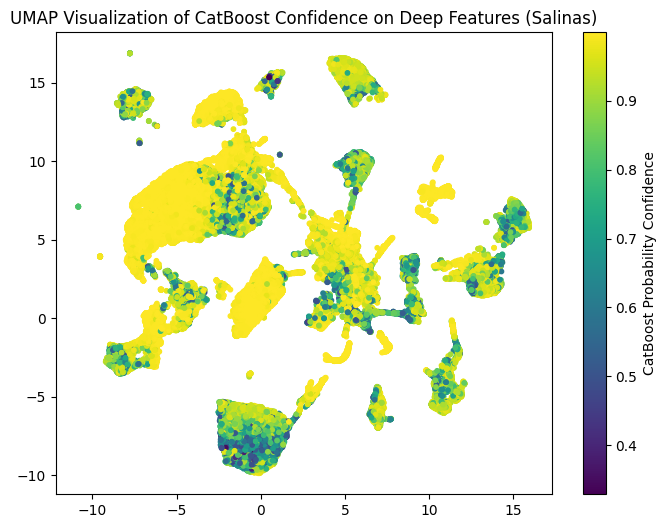

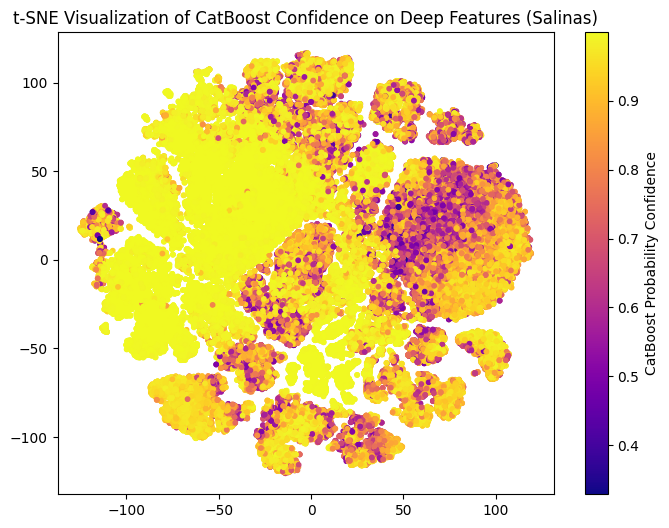

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
import seaborn as sns
import time

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),  # Changed 204 → 1
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")
model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device).unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -2].values

# ✅ Feature Extraction
start_inf = time.time()
with torch.no_grad():
    deep_features = model.feature_extractor(X_tensor).cpu().numpy()
inference_time = (time.time() - start_inf) * 1000
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")

# ✅ Train CatBoost
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth)

# ✅ Predict Probabilities
catboost_probs = catboost_model.predict_proba(deep_features)
max_probs = np.max(catboost_probs, axis=1)  # Softmax confidence for visualization

# ✅ UMAP Visualization
def plot_umap(features, probs):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)
    plt.figure(figsize=(8,6))
    sc = plt.scatter(embedding[:, 0], embedding[:, 1], c=probs, cmap='viridis', s=10)
    plt.colorbar(sc, label='CatBoost Probability Confidence')
    plt.title("UMAP Visualization of CatBoost Confidence on Deep Features (Salinas)")
    plt.show()

# ✅ t-SNE Visualization
def plot_tsne(features, probs):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    embedding = tsne.fit_transform(features)
    plt.figure(figsize=(8,6))
    sc = plt.scatter(embedding[:, 0], embedding[:, 1], c=probs, cmap='plasma', s=10)
    plt.colorbar(sc, label='CatBoost Probability Confidence')
    plt.title("t-SNE Visualization of CatBoost Confidence on Deep Features (Salinas)")
    plt.show()

# ✅ Plot Both Visualizations
plot_umap(deep_features, max_probs)
plot_tsne(deep_features, max_probs)

In [ ]:
average_confidence = np.mean(max_probs)
print(f"🔍 Average CatBoost Confidence (Salinas): {average_confidence:.4f}")

🔍 Average CatBoost Confidence (Salinas): 0.9081


In [ ]:
import torch.nn.functional as F
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
import os, time
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import torch.nn as nn

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),  # Changed 204 → 1
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")
model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device).unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -2].values

# ✅ Feature Extraction
start_inf = time.time()
with torch.no_grad():
    deep_features = model.feature_extractor(X_tensor).cpu().numpy()
inference_time = (time.time() - start_inf) * 1000
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")

class FeatureWrapper(nn.Module):
    def __init__(self, extractor):
        super().__init__()
        self.extractor = extractor

    def forward(self, x):
        return self.extractor(x)

# ✅ Train CatBoost
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 95.56 ms
0:	learn: 2.5433988	total: 85.3ms	remaining: 1m 25s
50:	learn: 0.5831120	total: 2.34s	remaining: 43.5s
100:	learn: 0.3645335	total: 4.53s	remaining: 40.3s
150:	learn: 0.3058845	total: 6.62s	remaining: 37.2s
200:	learn: 0.2803316	total: 8.68s	remaining: 34.5s
250:	learn: 0.2665440	total: 11.8s	remaining: 35.3s
300:	learn: 0.2561171	total: 14.7s	remaining: 34.2s
350:	learn: 0.2481952	total: 16.9s	remaining: 31.2s
400:	learn: 0.2413034	total: 18.9s	remaining: 28.2s
450:	learn: 0.2355261	total: 21.1s	remaining: 25.6s
500:	learn: 0.2304631	total: 23.1s	remaining: 23s
550:	learn: 0.2259023	total: 27.1s	remaining: 22.1s
600:	learn: 0.2216661	total: 29.2s	remaining: 19.4s
650:	learn: 0.2177400	total: 31.4s	remaining: 16.8s
700:	learn: 0.2142483	total: 33.4s	remaining: 14.3s
750:	learn: 0.2110785	total: 35.6s	remaining: 11.8s
800:	learn: 0.2078806	total: 38.8s	remaining: 9.64s
850:	learn: 0.2050501	tota

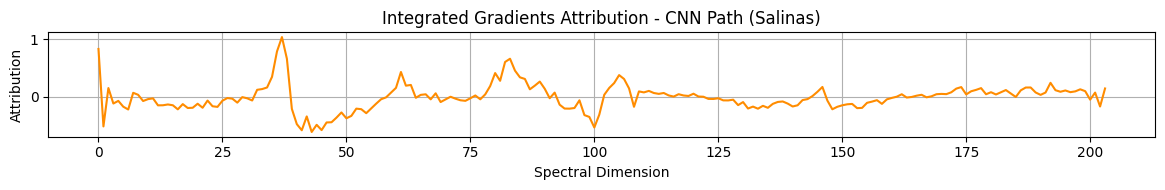

In [ ]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

# ✅ Wrap the CNN feature extractor
wrapped_model = FeatureWrapper(model.feature_extractor).to(device)
wrapped_model.eval()

# ✅ Select one input sample
sample_idx = 0
input_sample = X_tensor[sample_idx].unsqueeze(0).to(device)  # [1, 200]

# ✅ Enable gradient tracking
input_sample.requires_grad_()

# ✅ Create Integrated Gradients object
ig = IntegratedGradients(wrapped_model)

# ✅ Get prediction output for baseline class
output = wrapped_model(input_sample)
target_class = int(y_pred[sample_idx])  # Use predicted or true class

# ✅ Attribution computation
attributions, delta = ig.attribute(
    inputs=input_sample,
    target=target_class,
    return_convergence_delta=True,
    baselines=torch.zeros_like(input_sample)
)

# ✅ Convert to NumPy
attr = attributions.squeeze().detach().cpu().numpy()

# ✅ Plot
plt.figure(figsize=(12, 2))
plt.plot(attr, color="darkorange")
plt.title("Integrated Gradients Attribution - CNN Path (Salinas)")
plt.xlabel("Spectral Dimension")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()

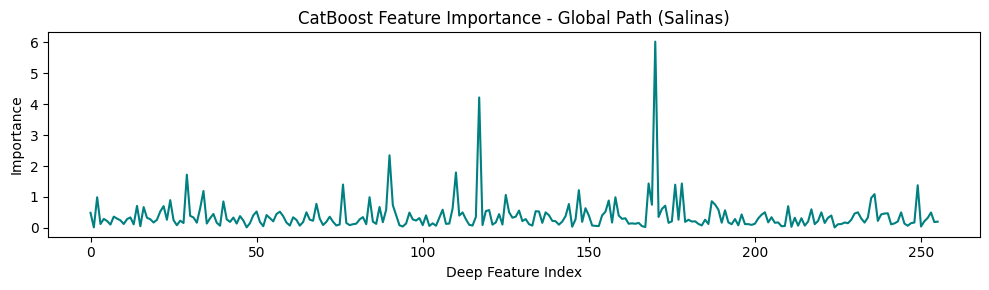

In [ ]:
# ✅ Feature Importance - CatBoost (Global Path)
importances = catboost_model.get_feature_importance()
plt.figure(figsize=(10, 3))
plt.plot(importances, color='teal')
plt.title("CatBoost Feature Importance - Global Path (Salinas)")
plt.xlabel("Deep Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

**500 ITERATIONS**

In [ ]:
!pip install catboost

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),  # Changed 204 → 1
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -2].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=6,
    loss_function='MultiClass',
    task_type="CPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

print(f"Final Iterations Used: {catboost_model.tree_count_}")
print(f"Learning Rate Used: {catboost_model.get_param('learning_rate')}")

from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score

accuracy_final = accuracy_score(y_ground_truth, y_pred)
kappa_final = cohen_kappa_score(y_ground_truth, y_pred)
ari_final = adjusted_rand_score(y_ground_truth, y_pred)

print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Kappa: {kappa_final:.4f}")
print(f"Final ARI: {ari_final:.4f}")

Using device: cpu
✅ Model successfully loaded on cpu
✅ Inference Time per Sample: 5586.79 ms
0:	learn: 2.7313929	total: 13.8s	remaining: 1h 54m 47s
50:	learn: 1.2115052	total: 6m 29s	remaining: 57m 13s


KeyboardInterrupt: 

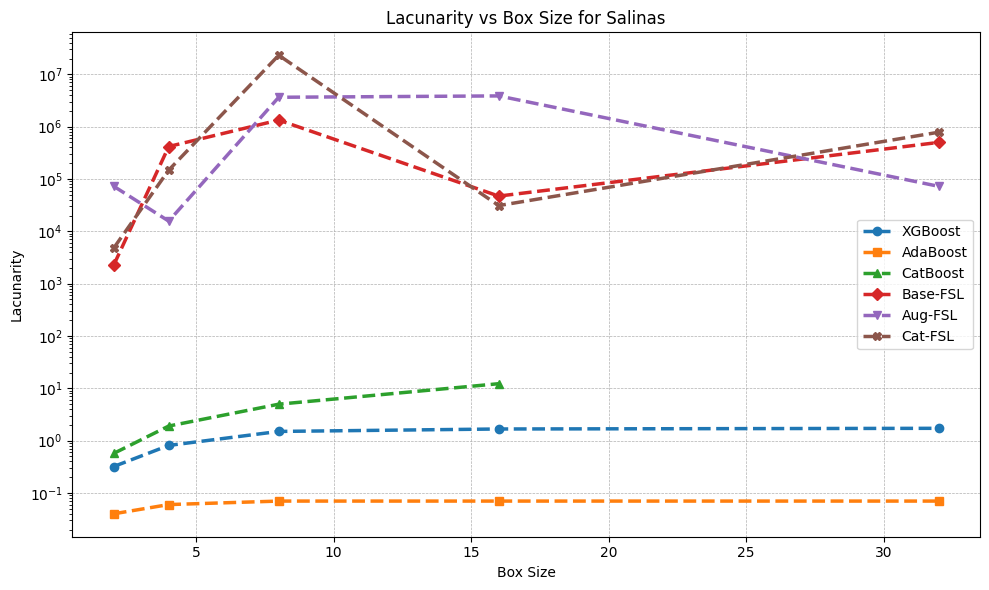

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
box_sizes = [2, 4, 8, 16, 32]
xgboost = [0.32, 0.81, 1.50, 1.67, 1.72]
adaboost = [0.04, 0.06, 0.07, 0.07, 0.07]
catboost = [0.57, 1.90, 4.97, 12.25, np.nan]  # NaN for missing

base_fsl = [2260.43, 417227.30, 1336921.00, 47116.40, 500118.90]
aug_fsl = [72635.60, 15683.75, 3644759.00, 3868715.00, 72353.64]
cat_fsl = [4782.98, 147758.00, 23142940.00, 31010.19, 783063.60]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(box_sizes, xgboost, marker='o', linestyle='--', label='XGBoost', linewidth=2.5)
plt.plot(box_sizes, adaboost, marker='s', linestyle='--', label='AdaBoost', linewidth=2.5)
plt.plot(box_sizes, catboost, marker='^', linestyle='--', label='CatBoost', linewidth=2.5)

plt.plot(box_sizes, base_fsl, marker='D', linestyle='--', label='Base-FSL', linewidth=2.5)
plt.plot(box_sizes, aug_fsl, marker='v', linestyle='--', label='Aug-FSL', linewidth=2.5)
plt.plot(box_sizes, cat_fsl, marker='X', linestyle='--', label='Cat-FSL', linewidth=2.5)

plt.xlabel("Box Size")
plt.ylabel("Lacunarity")
plt.title("Lacunarity vs Box Size for Salinas")
plt.yscale("log")  # Log scale for better visualization
plt.grid(True, which="major", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()